In [137]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette("RdBu")
import ipywidgets as widgets  # interactive display
my_layout = widgets.Layout()

# Setup

## Plotting functions

In [138]:
# Plot membrane potential 
def plot_V_m(V_neuron, spike_times, time):
  """
  Plot membrane potential of a single neuron

  Args:
  V_neuron    : Voltage of a single neuron
  spike_times : spike train

  Returns:
  Figure of the membrane potential trajetory for a single neuron
  """
  if spike_times.size:
    spike_times_int = (spike_times / dt).astype(int) # - 1
    V_neuron[spike_times_int] += 40  # draw part of spike above threshold

  plt.plot(time, V_neuron, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.plot(spike_times,np.max(V_neuron)+0*spike_times,'ro')
  plt.xlabel('Time (ms)')
  plt.ylabel('Membrane potential (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
            loc=[1.05, 0.75])
  plt.ylim([-75, 0])
  plt.show()


# Plot the raster of spike train
def plot_raster(spikes_matrix):
  """
  Makes raster plot with spike trains

  Args:
    spike_matrix : binary spike trains, with shape (N, Lt)

  Returns:
    Raster plot of the Poisson spike train
  """

  plt.figure()
  plt.plot(spikes_matrix[0],spikes_matrix[1],'k.')
  plt.ylabel('Index of spiking neuron')
  plt.xlabel('Time (ms)')
  plt.show()

# plot input-output function
def plot_io_curve(spike_frequency_df):
  """
  Makes function showing the relationship between 
  injected current and frequency of neuronal spikes

  Args:
    spike_frequency_df : DataFrame with columns of injected
                         current and spiking frequency

  Returns:
    I/O function plot
  """
  figure = sns.relplot(x = "injected_current",
              y = "spiking_frequency",
              data = spike_frequency_df,
              kind = "line",
              markers = True,
              dashes = False,
              )
  figure.set(xlabel = "Injected current (pA)",
             ylabel = "Spiking frequency (Hz)")
  plt.show()

## Model functions

In [139]:
# Generate Poisson spike trains

def generate_poisson_spikes(N_p, rate_p, j_p, tau_p, myseed = False):
  """
  Generates poisson spike trains

  Args:
    pars                      : parameter dictionary
    myseed                    : random seed. int or boolean
    N_p                       : number of Poisson neurons
    rate_p                    : noise amplitute [Hz] 
    j_p                       : Poisson synaptic weight
    tau_p                     : Poisson synaptic constant

  Returns:
    poisson_spikes_matrix     : matrix with two rows - poisson_spikes_matrix[0,:] -
                              a vector of spike times and poisson_spikes_matrix[1,:] 
                              is a vector of associated neuron indices
    I_p                       : Input current [pA] (here: generated by Poisson distribution)
    I_p_bar                   : Theoretical input current [pA]
    poisson_spikes_int        : Total number of Poisson spikes
  """
 
  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # The total number of spikes obeys a Poisson
  # distribution with expectation rx*Nx*T
  poisson_spikes_int = np.random.poisson(ratio_p*N_p*T)
  poisson_spikes_matrix = np.zeros((2,poisson_spikes_int))

  # Spike times and indices are uniformly distributed
  # once we condition on the total number of spikes
  poisson_spikes_matrix[0,:] = np.random.rand(poisson_spikes_int)*T
  poisson_spikes_matrix[1,:] = np.random.randint(0,N_p,size=poisson_spikes_int)

  # Sort spike times 
  sort=np.argsort(poisson_spikes_matrix[0,:])
  poisson_spikes_matrix=poisson_spikes_matrix[:,sort]

  # Initialize Input current
  I_p = np.zeros_like(time)

  # Implement the ODE version of the Ix model
  i_p = 0
  for i in range(1,len(time)):
    I_p[i] = I_p[i-1]-dt*I_p[i-1]/tau_p
    while (i_p < poisson_spikes_int and poisson_spikes_matrix[0,i_p] <= i*dt):
      I_p[i] += j_p/tau_p
      i_p += 1

  # Calculate theoretical stationary mean value
  # of I_p, i.e., E[I_p]
  I_p_bar = N_p*j_p*ratio_p

  print('Theoretical mean of Poisson input current:', I_p_bar)
  print('Empirical mean of Poisson input current:', np.mean(I_p))

  return poisson_spikes_matrix, I_p, I_p_bar, poisson_spikes_int


# run single neuron model
def run_EIF(I_pre, I_int = False, comments = False):
  """
  Simulate a single neuron modeled as Exponential Integrate and Fire (EIF) neuron dynamics with external input current

  Args:
    I_pre             : presynaptic input current [pA] (value or an array)
    I_int             : true when it is constant current, not an array

  Returns:
    spike_times       : spike times [ms] (array)
    V_neuron          : mebrane potential [mV] (array)
    spiking_frequency : frequency of neuronal spikes in Hz (int)
  """
  # Initialize membrane potential and external current
  V_neuron = np.zeros(len(time))
  V_neuron[0] = V_init

  # Depending whether neuron receives injected current (I_inj) or poisson spikes (I_p)
  if I_int == True:
    I_pre = I_pre * np.ones(len(time))
  # else
  #   I_pre

  # Initialize postsynaptic spike train vector
  spike_times = np.zeros(len(time)) # record spike times
  spike_int = 0
  
  # Simulate EIF dynamics
  for i in range(1,len(time)):
    # Update the membane potential
    V_neuron[i] = V_neuron[i-1]+dt*(I_pre[i-1]/g_L+(E_L-V_neuron[i-1])+t_ref*np.exp((V_neuron[i-1]-V_th)/t_ref))/tau_m
    V_neuron[i] = np.maximum(V_neuron[i],V_lb)

    # if there is a spike
    if (V_neuron[i] >= V_th):    
      V_neuron[i] = V_reset
      V_neuron[i-1] = V_th # This just makes plots look nicer
      spike_times[spike_int] = i*dt
      spike_int += 1

  
  #Calculating firing rate in Hz
  rate=(spike_int)/T
  spiking_frequency = 1000*rate # in Hz

  # Printing comments in cells (optional)
  if comments == True:
    # Compute rate
    print("Number of spikes:", spike_int)
    print('Postsynaptic rate =', spiking_frequency, 'Hz')

  return V_neuron, spike_times, spiking_frequency


# Input-Output function
def run_IO(I_min = 0, I_max = 500, step = 10):
  """
  run stimulation with increasing current steps and measure frequency of EIF neuron

  Args:
    I_min             : minimal current step applied (pA)
    I_max             : maximal current step applied (pA)
    step              : difference between current steps (pA)

  Returns:
    spiking_df        : DataFrame with the spiking frequency and current steps
  """
#Initializing input current and vectors
  I_inj = np.arange(I_min, I_max, step)
  spiking_array = np.zeros(((len(I_inj), 2)))

  # Stimulate neurons with external current of increasing amplitudes and store frequency and current amplitude
  for index, inj in enumerate(I_inj):
      V_neuron, spike_times, spiking_frequency = run_EIF(I_pre = inj, I_int = True, comments= False)
      spiking_array[index,0] = inj
      spiking_array[index,1] = spiking_frequency

  # change array to pandas DataFrame
  spiking_df = pd.DataFrame(spiking_array, index = None)
  spiking_df.columns = ["injected_current", "spiking_frequency"]

  return spiking_df

## Parameters

In [140]:
# Defining parameters

# typical neuron parameters#
C_m = 200       # membrane capacitance [pF] 
g_L = 10        # leak conductance [nS]
E_L = -75       # leak reversal potential [mV] 
V_th = -50      # threshold current
V_reset = -65   # Post-spike reset potential [mV]
tau_m = 24      # membrane time constant [ms] 
V_init = -65    # initial potential [mV] 
t_ref = 2       # absolute refractory time (ms) 
V_lb = -80      # lower boundary

# typical Poisson input parameters#
tau_p = 5       # Poisson time constant [ms]
j_p = 150        # Poisson weight 
N_p= 350        # number of Poisson neurons  
ratio_p = 5/1000# noise amplitute [Hz] 

# typical excitatory and inhibitory synaptic transmission parameters
V_e = 0         # Excitatory reversal potential [mV]
V_i = -85       # Inhibitory reversal potential [mV]
N_e = 340       # nr of excitatory neurons 
N_i = 60        # nr of inhibitory neurons 
tau_e = 8       # excitatory synaptic conductance time constant [ms]
tau_i = 4       # inhibitory synaptic conductance time constant [ms] 

# Connection probabilities
pee = 0.01      # connection probability of exc to exc cell 
pei = 0.15      # connection probability of inh to exc cell 
pie = 0.15      # connection probability of exc to inh cell 
pii = 0.1       # connection probability of inh to inh cell 
pex = 0.1       # connection probability of Poisson to exc cell
pix = 0.1       # connection probability of Poisson to inh cell

# Synaptic weights
jee = 350       # synaptic weight from exc to exc cell 
jei = -2100     # synaptic weight from inh to exc cell
jie = 2000      # synaptic weight from exc to inh cell 
jii = -3500     # synaptic weight from inh to inh cell
jex = 2250      # synaptic weight from Poisson to exc cell 
jix = 2000      # synaptic weight from Poisson to inh cell 

# Conductances
gE_bar = 2.4    # excitatory conductance [nS] 
gI_bar = 2.4    # inhibitory conductance [nS]

# Simulation parameters 
T = 1000      # Total duration of simulation [ms]
dt = .1         # Simulation time step [ms]

# Time vector
time = np.arange(0, T, dt)  # Vector of discretized time points [ms]


# Modeling a postsynaptic neuron and simulating it with an inject external (i.e., "injected") current

Here I model the membrane potential of a postsynaptic neuron using the exponential integrate-and-fire (EIF) model, which obeys the ODE
$$
\tau_m \frac{dV}{dt}=-(V_{neuron}-E_L)+t_{ref} e^{(V_{neuron}-V_{th})/t_{ref}}+I_p
$$
with the added condition
$$
V_{neuron}(t)\ge V_{th}\Rightarrow V_{neuron}(t)\gets V_{reset},\textrm{record a spike}
$$

Number of spikes: 31
Postsynaptic rate = 31.0 Hz


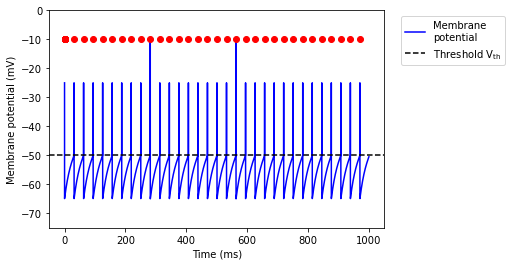

In [141]:
V_neuron, spike_times, _ = run_EIF(I_pre = 300, I_int = True, comments= True)
plot_V_m(V_neuron, spike_times, time)

## Explore amplitude of the input current
We can see above that when I inject 300pA external current, this particular neuron with properties described in parameteres section, produces 3 action potentials (spikes). Note that these are just cosmetic spikes only for illustration purposes. In this type of model, we only need to keep track of times when the neuron hit the threshold so the postsynaptic neurons can be informed of the spike. The properties of these spikes are ignored.

Nevertheless, when we change the amount of injected current, the response of this neurons changes. It can be visualize below.

In [142]:
# Widget with injected current
# my_layout.width = '450px'
# @widgets.interact(
#     injected_current=widgets.FloatSlider(50, min=0, max=500, step=20,
#                                layout=my_layout))

# def different_I_inj(I_inj=200, V_neuron, spike_times, time):
#   V_neuron, spike_times, _ = run_EIF(I_int = True, comments = False)
#   plot_V_m(V_neuron, spike_times, time)
#   plt.show()

## Input-output function
In electrophysiological studies, the number of spikes which neurons produce in a given time to increasing current steps is called "Input-Output Fuction". For this particular neuron, it looks like it:

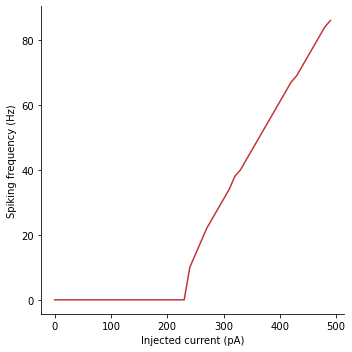

In [143]:
spike_frequency_df = run_IO()
plot_io_curve(spike_frequency_df) 

# Simulate neuron with synaptic current modeled as Poisson process

In brain networks, a neuron receives input current not as a fixed injected current but as a sum of synaptic contacts that other neurons made on it. It can be modeled as Poisson process. 

## Poisson process
`poisson_spikes_matrix ` is a family of $N_p$ Poisson processes modeling the spike times of $N_p$ neurons. It is stored as a matrix with two rows. The first row, `poisson_spikes_matrix[0,:]`, is a vector of spike times (random numbers in $[0,T]$) and `poisson_spikes_matrix[1,:]` is a vector of associated neuron indices (integers from  $0$ to  $N_p-1$). 

Theoretical mean of Poisson input current: 262.5
Empirical mean of Poisson input current: 252.25910423230957


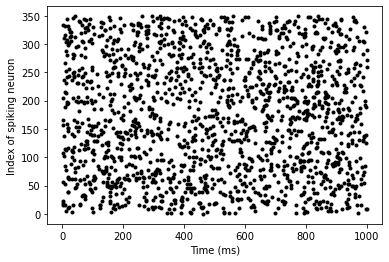

In [144]:
# Simulate Poisson spikes
poisson_spikes_matrix, I_p, I_p_bar, poisson_spikes_int = generate_poisson_spikes(N_p, ratio_p, j_p, tau_p, myseed = 2022)
# Plot Poisson spikes
plot_raster(poisson_spikes_matrix)
# Simulate single neuron 

## Equasions
We assume that our neuron receives excitatory synaptic input from all  $N_p$ neurons (each neuron is represented as a row of a raster plot showed above) modeled by the Poisson processes above. These neurons produce spikes (dots above) in specific time during our simulation, which evokes an expontentially decaying current pulse so the current is given by 
$$
I_p(t)=\sum_{k=1}^{N_p}j_p\sum_i \alpha_x(t-t_{i,k})
$$
where $t_{i,k}$ is the $i$th spike time of neuron $k=1,\ldots,N_p$,
$$
\alpha_p(t)=e^{-t/\tau_p}H(t),
$$
and $H(t)$ is the Heavisde step function. The current can equivalently be modeled by the ODE
$$
\tau_p\frac{dI_p}{dt}=-I_p
$$
with the added rule
$$
I_p(t_{i,k})\gets I_p(t_{i,k})+j_p/\tau_p
$$

**Theory:** The mean synaptic current is  given by 
$$
\overline{I}_p=N_p j_p r_p
$$

Now model the membrane potential of a postsynaptic neuron using the exponential integrate-and-fire (EIF) model, which obeys the ODE
$$
\tau_m \frac{dV_{neuron}}{dt}=-(V_{neuron}-E_L)+t_{ref} e^{(V_{neuron}-V_{th})/t_{ref}}+I_p
$$
with the added condition
$$
V_{neuron}(t)\ge V_{th}\Rightarrow V_{neuron}(t)\gets V_{reset},\textrm{ record a spike}
$$

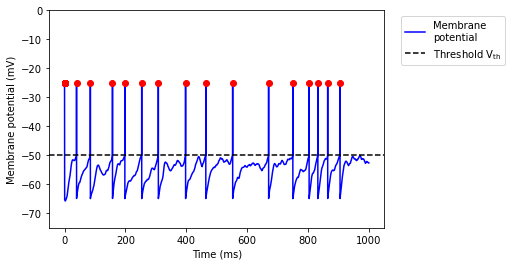

In [145]:
# Response of postsynaptic neuron to Poisson spikes
V_neuron, poisson_spike_times, _ = run_EIF(I_pre = I_p, I_int = False, comments= False)
plot_V_m(V_neuron, poisson_spike_times, time)